It is highly recommended to use a powerful **GPU**, you can use it for free uploading this notebook to [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb).
<table align="center">
 <td align="center"><a target="_blank" href="https://colab.research.google.com/github/mehrerm/intro_deep_learning/blob/main/class/RNN/img2seq.ipynb">
        <img src="https://colab.research.google.com/img/colab_favicon_256px.png"  width="50" height="50" style="padding-bottom:5px;" />Run in Google Colab</a></td>
  <td align="center"><a target="_blank" href="https://github.com/mehrerm/intro_deep_learning/blob/main/class/RNN/img2seq.ipynb">
        <img src="https://github.githubassets.com/images/modules/logos_page/GitHub-Mark.png"  width="50" height="50" style="padding-bottom:5px;" />View Source on GitHub</a></td>
</table>

## Generate CAPTCHA Dataset

In [1]:
import string
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import tensorflow as tf
from IPython.display import Image, display

In [2]:
chars = set()
#chars.update(string.ascii_lowercase)
#chars.update(string.ascii_uppercase)
chars.update({str(i) for i in range(10)})
chars = sorted(chars)
print('Number of chars: {0}, chars: {1}'.format(len(chars), chars))

Number of chars: 10, chars: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [3]:
img_dir = './captcha/'
if not os.path.exists(img_dir):
    os.makedirs(img_dir)

In [4]:
!pip install captcha

In [5]:
from captcha.image import ImageCaptcha
import uuid
create_dataset = True
captcha_len = 3
width = 40 + 20 * captcha_len
height = 100
n_images = 40000
if create_dataset:
    image = ImageCaptcha(width = width, height = height)
    print('Sample captcha str', np.random.choice(chars, captcha_len))
    seen = set()
    for _ in tqdm(range(n_images)):
        combi = np.random.choice(chars, captcha_len)
        captcha = ''.join(combi)
        image.write(captcha, '{0}{1}_{2}.png'.format(img_dir, captcha, uuid.uuid4()))

Sample captcha str ['7' '6' '1']


100%|██████████| 40000/40000 [03:01<00:00, 220.34it/s]


In [6]:
print('Number of captchas', len(os.listdir(img_dir)))
print('Some captchas', os.listdir(img_dir)[:5])

Number of captchas 40000
Some captchas ['436_e2e3d7e1-1a2b-4827-a476-5f4293466aec.png', '603_bba14696-6758-4588-97ab-9b3a13e090ce.png', '398_6671a8dc-1f23-4152-8fd0-b69d8d9634ff.png', '244_908cb2e6-eec4-412b-8aea-aadd93b517f5.png', '460_8bd611ab-4bd7-410f-ba1d-7c960fd3eee1.png']


image shape:  (100, 100, 3)


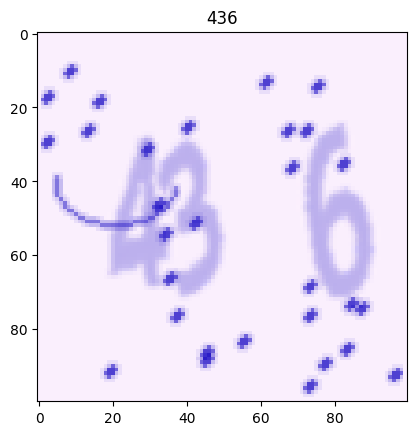

In [7]:
## Plot first sample
name = os.listdir(img_dir)[0]
x = tf.keras.preprocessing.image.load_img(os.path.join(img_dir, name))
x = tf.keras.preprocessing.image.img_to_array(x).astype(np.uint8)
print('image shape: ', x.shape)
plt.imshow(x)
plt.title(name.split('_')[0])
plt.show()

## Preprocessing data

Number of images found:  40000
Number of labels found:  40000
Number of unique characters:  10
Characters present:  ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


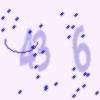

captcha: 436


In [8]:
data_dir = img_dir
# Get list of all the images
images, labels = zip(*[(os.path.join(img_dir, name), name.split('_')[0])
                       for name in os.listdir(img_dir)])
images, labels = (np.array(list(images)), np.array(list(labels)))
characters = sorted(set(char for label in labels for char in label))

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)
display(Image(images[0]))
print('captcha:', labels[0])

### Characters processing
For converting the characters to one-hot encoding, we will use [tf.keras.layers.experimental.preprocessing.StringLookup
](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/StringLookup).
```python
tf.keras.layers.experimental.preprocessing.StringLookup(
    max_tokens=None, num_oov_indices=1, mask_token='',
    oov_token='[UNK]', vocabulary=None, encoding=None, invert=False,
    **kwargs
)
```

In [12]:
# Mapping characters to integers
##char_to_num = layers.experimental.preprocessing.StringLookup(
char_to_num = layers.StringLookup(
    vocabulary=list(characters), num_oov_indices=0, mask_token=None
)

# Mapping integers back to original characters
##num_to_char = layers.experimental.preprocessing.StringLookup(
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), num_oov_indices=0,
    mask_token=None, invert=True
)


train_samples = int(0.7 * len(images))
val_split = int(0.8 * len(images))
x_train, y_train = images[:train_samples], labels[:train_samples]
x_val, y_val = images[train_samples:val_split], labels[train_samples:val_split]
x_test, y_test = images[val_split:], labels[val_split:]
print('x_train, y_train shape: ', x_train.shape, y_train.shape)

def encode_single_sample(img_path, label):

    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    zeros = tf.zeros((captcha_len,1))
    return ((img, zeros), label)


x_train, y_train shape:  (28000,) (28000,)


### Generate Datasets

In [13]:
batch_size = 128
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).map(encode_single_sample)
train_dataset = train_dataset.batch(batch_size).cache().shuffle(50).prefetch(buffer_size=AUTOTUNE)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val)).map(encode_single_sample)
validation_dataset = validation_dataset.batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).map(encode_single_sample)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE).batch(batch_size)

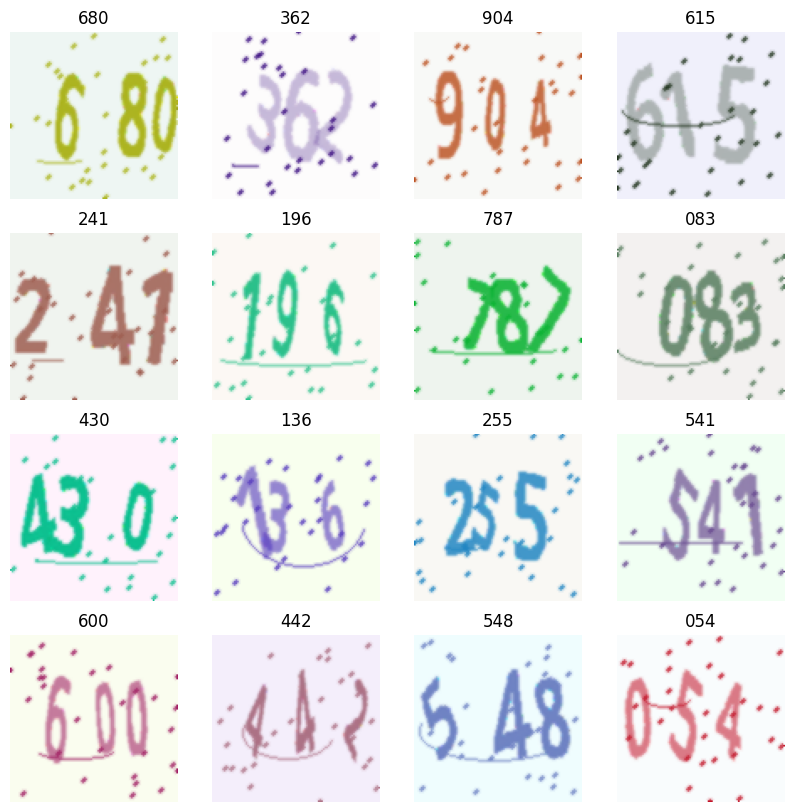

In [14]:
# plot samples
_, ax = plt.subplots(4, 4, figsize=(10, 10))
for (images_batch, zeros_batch), labels_batch in train_dataset.take(1):
    for i in range(16):
        img = (images_batch[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels_batch[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

## Questions 1: Create a model like a seq2seq
Study the impact of `encoder_vec_dim` on the performance of the model.

In [15]:
encoder_vec_dim = ...  # dimension of the encoder vector

# Encoder
encoder_input = tf.keras.Input(shape=(height, width, 3), name='encoder_input')

## Convolution + pooling layers
...
## Flatten()
...



# encoded_vector
x = layers.Dense(encoder_vec_dim, activation='relu')(...)
encoded_vector = [x, x]



# Decoder: encoded_vector is the input state to the first decoder RNN
decoder_input = tf.keras.Input(shape=(captcha_len, 1), name='decoder_input')
decoder_output = layers.LSTM(encoder_vec_dim,
                             return_sequences=True,
                             name="decoder")(decoder_input,
                                             initial_state=encoded_vector)
output = layers.TimeDistributed(
    layers.Dense(len(characters) + 1, activation='softmax'))(decoder_output)






model = tf.keras.Model([encoder_input, decoder_input], output)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer='adam',
              metrics=["accuracy"])
model.summary()

ValueError: Only input tensors may be passed as positional arguments. The following argument value should be passed as a keyword argument: Ellipsis (of type <class 'ellipsis'>)

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True)

In [ ]:
epochs = 300
early_stopping_patience = 50
# Add early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
)

### Evaluate Test Results

In [ ]:
results = model.evaluate(test_dataset, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

In [ ]:
_, ax = plt.subplots(4, 4, figsize=(12, 12))
for (images_batch, zeros_batch), labels_batch in test_dataset.take(1):
    y_preds = model.predict([images_batch, zeros_batch]).argmax(-1)
    for i in range(16):
        img = (images_batch[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(
            labels_batch[i])).numpy().decode("utf-8")
        label_pred = tf.strings.reduce_join(num_to_char(
            y_preds[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        if label == label_pred:
            ax[i // 4,
               i % 4].set_title('real:{0}, pred:{1}'.format(label, label_pred),
                                color='green')
        else:
            ax[i // 4,
               i % 4].set_title('real:{0}, pred:{1}'.format(label, label_pred),
                                color='red')
        ax[i // 4, i % 4].axis("off")

plt.show()

In [ ]:
#pretrained_model = tf.keras.applications.MobileNetV2(input_shape=(width, height, 3), include_top=False)
#pretrained_model.trainable = False

### Extra: Visual Attention

In [ ]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # attention_hidden_layer shape == (batch_size, 64, units)
        attention_hidden_layer = (
            tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)))

        # score shape == (batch_size, 64, 1)
        # This gives you an unnormalized score for each image feature.
        score = self.V(attention_hidden_layer)

        # attention_weights shape == (batch_size, 64, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights


class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x


class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

embedding_dim = 16
vocab_size = len(characters) + 1
units = 32
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                            reduction='none')


def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [ ]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []


@tf.function
def train_step(img_tensor, target):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] *
                               target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss




In [ ]:
import time
EPOCHS = 20

for epoch in range(1, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, ((images_batch, _), labels_batch)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(images_batch, labels_batch)
        total_loss += t_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(
                epoch + 1, batch,
                batch_loss.numpy() / int(labels_batch.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
        ckpt_manager.save()

    print('Epoch {} Loss {:.6f}'.format(epoch + 1, total_loss / num_steps))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

In [ ]:
 in train_dataset.take(1)

## Extra: Audio Captcha

In [ ]:
from IPython import display
aud_dir = './captcha_audio/'
if not os.path.exists(aud_dir):
    os.makedirs(aud_dir)

In [ ]:
from captcha.image import ImageCaptcha
from captcha.audio import AudioCaptcha

audio = AudioCaptcha()


In [ ]:
#!pip install wavio

In [ ]:
import uuid
import wavio
captcha_len = 3
n_audios = 50
audio = AudioCaptcha()
print('Sample captcha str', np.random.choice(chars, captcha_len))
seen = set()
for _ in tqdm(range(n_audios)):
    combi = np.random.choice(chars, captcha_len)
    captcha = ''.join(combi)
    captcha_path = '{0}{1}_{2}.wav'.format(aud_dir, captcha, uuid.uuid4())
    audio.write(captcha, captcha_path)

    wav = wavio.read(captcha_path).data
    # convert to 16-bits
    max_val = 2 ** 16 - 1
    wav = (wav / 255.0 * max_val).astype(np.int16)
    wav_tf = tf.audio.encode_wav(
    wav, 8000, name=None
    )
    os. remove(captcha_path)
    tf.io.write_file(
    captcha_path, wav_tf, name=None
    )

In [ ]:
print('Number of captchas', len(os.listdir(aud_dir)))
print('Some captchas', os.listdir(aud_dir)[:5])

In [ ]:
file_path = os.path.join(aud_dir, os.listdir(aud_dir)[0])
audio_binary = tf.io.read_file(file_path)
audio, _ = tf.audio.decode_wav(audio_binary)
print(audio.shape)
waveform = tf.squeeze(audio, axis=-1)
print(waveform.shape)
print('captcha',os.listdir(aud_dir)[0].split('_')[0])
display.display(display.Audio(waveform, rate=8000))

In [ ]:
# Get list of all the images
audios, labels = zip(*[(os.path.join(aud_dir, name), name.split('_')[0])
                       for name in os.listdir(aud_dir)])
audios, labels = (np.array(list(audios)), np.array(list(labels)))
characters = sorted(set(char for label in labels for char in label))
print("Number of audios found: ", len(audios))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)


In [ ]:
# Mapping characters to integers
char_to_num = layers.experimental.preprocessing.StringLookup(
    vocabulary=list(characters), num_oov_indices=0, mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)



train_samples = int(0.7 * len(audios))
val_split = int(0.8 * len(audios))
x_train, y_train = audios[:train_samples], labels[:train_samples]
x_val, y_val = audios[train_samples:val_split], labels[train_samples:val_split]
x_test, y_test = audios[val_split:], labels[val_split:]
print('x_train, y_train shape: ', x_train.shape, y_train.shape)

def encode_single_sample(aud_path, label):

    audio_binary = tf.io.read_file(aud_path)
    audio, _ = tf.audio.decode_wav(audio_binary)
    waveform = tf.squeeze(audio, axis=-1)[:70000]

    zero_padding = tf.zeros([70000] - tf.shape(waveform), dtype=tf.float32)

    # Concatenate audio with padding so that all audio clips will be of the
    # same length
    waveform = tf.cast(waveform, tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)

    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    zeros = tf.zeros((captcha_len,1))
    return ((equal_length, zeros), label)


### Generate Datasets

In [ ]:
batch_size = 128
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).map(encode_single_sample)
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE).batch(batch_size)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val)).map(encode_single_sample)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).map(encode_single_sample)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE).batch(batch_size)

In [ ]:
for (audios_batch, zeros_batch), labels_batch in train_dataset.take(1):
    for i in range(4):
        label = tf.strings.reduce_join(num_to_char(labels_batch[i])).numpy().decode("utf-8")
        print('captcha',label)
        display.display(display.Audio(audios_batch[i], rate=8000))
